# DenseNet Architecture

In [1]:
import os
import pathlib

import tensorflow as tf
from bcd.model.repo import ModelRepo
from bcd.model.factory import DenseNetFactory
from bcd.model.visual import X4LearningVisualizer
from bcd.model.transfer import thaw

In [2]:
batch_size = 32
input_shape = (224,224,3)
output_shape = 1

initial_epochs = 100  # Number of epochs to train for feature extraction

fine_tune_epochs = 10  # Number of epochs for each fine tune session
fine_tune_thaw_rate = 0.05  # Additional proportion of layers to unthaw each fine tune session. 

early_stop_monitor = "val_loss"  # Monitor validation loss for early stopping
early_stop_patience = 3  # The number of consecutive epochs for which lack of improvement is tolerated 
early_stop_restore_best_weights = True  # Returns the best weights rather than the weights at the last epoch.

learning_rate = 0.0001  # Base learning rate for the Adam optimizer 
learning_rate_decay = 10 # The factor by which learning rate decays for each fine tune session.

loss = "binary_crossentropy"
activation = "sigmoid"
metric = "accuracy"

train_dir_10 = pathlib.Path("data/image/1_final/training_10/training/").with_suffix('')
test_dir = pathlib.Path("data/image/1_final/test/test/").with_suffix('')
checkpoint_filepath = "models/densenet/densenet{epoch:02d}-{val_loss:.2f}.keras"

## Preliminaries - Callbacks
Create a callback checkpoint that will automatically save model weights at each epoch.

In [3]:
# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                         mode="auto",
                                                         save_weights_only=False,
                                                         save_best_only=True, # save only the best model weights instead of a model every epoch
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

In [4]:
# Create an early stopping callback that will stop training if validation loss doesn't improve in n epochs
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor=early_stop_monitor, patience=early_stop_patience, restore_best_weights=early_stop_restore_best_weights)

## Load Data

In [5]:
# Training DataSet (10%)
train_ds_10 = tf.keras.utils.image_dataset_from_directory(
    train_dir_10,
    labels="inferred",
    color_mode="rgb",
    image_size=(224,224),
    shuffle=True,
    validation_split=0.2,
    subset='training',
    interpolation="bilinear",
    seed=123,
    batch_size=batch_size)

# Validation DataSet (10%)
val_ds_10 = tf.keras.utils.image_dataset_from_directory(
    train_dir_10,
    labels="inferred",
    color_mode="rgb",
    image_size=(224,224),
    shuffle=True,
    validation_split=0.2,
    subset='validation',
    interpolation="bilinear",
    seed=123,
    batch_size=batch_size)

# Test Set
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    color_mode="rgb",
    image_size=(224,224),
    shuffle=True)

Found 276 files belonging to 2 classes.
Using 221 files for training.
Found 276 files belonging to 2 classes.
Using 55 files for validation.
Found 649 files belonging to 2 classes.


## Feature Extraction

In [6]:
factory = DenseNetFactory()
densenet = factory.create(input_shape=input_shape, output_shape=output_shape, learning_rate=learning_rate, trainable=False, loss=loss, activation=activation, metric=metric)
densenet_history = densenet.fit(train_ds_10, epochs=initial_epochs, validation_data=val_ds_10, callbacks=[checkpoint_callback, early_stop_callback])

Epoch 1/5
7/7 [==============================] - ETA: 0s - loss: 0.7051 - accuracy: 0.5339
Epoch 1: val_loss improved from inf to 0.67693, saving model to models/checkpoints/densenet.ckpt
7/7 [==============================] - 57s 6s/step - loss: 0.7051 - accuracy: 0.5339 - val_loss: 0.6769 - val_accuracy: 0.5818
Epoch 2/5
7/7 [==============================] - ETA: 0s - loss: 0.7149 - accuracy: 0.5475
Epoch 2: val_loss improved from 0.67693 to 0.66639, saving model to models/checkpoints/densenet.ckpt
7/7 [==============================] - 40s 5s/step - loss: 0.7149 - accuracy: 0.5475 - val_loss: 0.6664 - val_accuracy: 0.5818
Epoch 3/5
7/7 [==============================] - ETA: 0s - loss: 0.6905 - accuracy: 0.6154
Epoch 3: val_loss improved from 0.66639 to 0.65959, saving model to models/checkpoints/densenet.ckpt
7/7 [==============================] - 39s 5s/step - loss: 0.6905 - accuracy: 0.6154 - val_loss: 0.6596 - val_accuracy: 0.6182
Epoch 4/5
7/7 [==============================] 

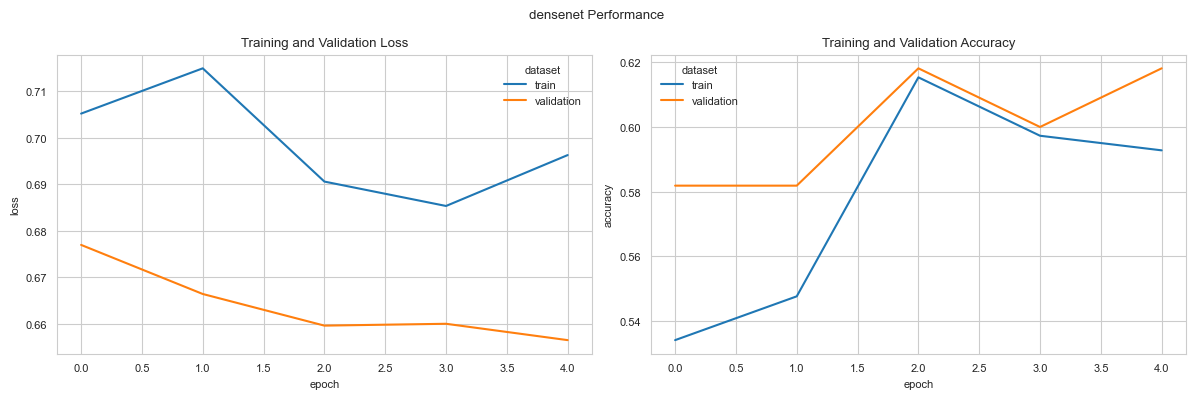

In [7]:
x4v = X4LearningVisualizer(name="densenet")
x4v(history=densenet_history)

We have an training accuracy of 60% and validation accuracy of 70% on 10% of the data in just 5 epochs. 

In [8]:
densenet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                             

Save the model.

In [ ]:
name="densenet"
description = "feature_extraction"
repo = ModelRepo()
repo.add(model=densenet, name=name, description=description, history=densenet_history)

## Fine Tune

### Resume Strategy

#### Fine Tune Session 1

In [9]:
fine_tune_session = 1
densenet_ft_epochs = initial_epochs + (fine_tune_epochs * fine_tune_session)
densenet_base_layer = 5

# Thaw the top n layers
densenet = thaw(model=densenet, base_model_layer=densenet_base_layer, session=fine_tune_session, thaw_rate = 0.05)

# Decay the learning rate
learning_rate = learning_rate / learning_rate_decay

# Recompile the model
densenet.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=(learning_rate/(learning_rate_decay**fine_tune_session))), metrics=[metric])

# Check trainable weights in summary
densenet.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                             

In [10]:

densenet_history_ft_1 = densenet.fit(train_ds_10, epochs=densenet_ft_epochs, validation_data=val_ds_10, 
                                         initial_epoch=densenet_history.epoch[-1],
                                         callbacks=[checkpoint_callback, early_stop_callback])
filename = "densenet_fine_tuning_1_1.keras"
filepath = os.path.join(model_directory, filename)
densenet.save(filepath)

Epoch 5/110
7/7 [==============================] - ETA: 0s - loss: 0.7087 - accuracy: 0.5792
Epoch 5: val_loss improved from 0.65648 to 0.65601, saving model to models/checkpoints/densenet.ckpt
7/7 [==============================] - 59s 6s/step - loss: 0.7087 - accuracy: 0.5792 - val_loss: 0.6560 - val_accuracy: 0.6182
Epoch 6/110
7/7 [==============================] - ETA: 0s - loss: 0.6741 - accuracy: 0.5882
Epoch 6: val_loss did not improve from 0.65601
7/7 [==============================] - 44s 6s/step - loss: 0.6741 - accuracy: 0.5882 - val_loss: 0.6563 - val_accuracy: 0.6182
Epoch 7/110
7/7 [==============================] - ETA: 0s - loss: 0.6956 - accuracy: 0.5611
Epoch 7: val_loss did not improve from 0.65601
7/7 [==============================] - 42s 6s/step - loss: 0.6956 - accuracy: 0.5611 - val_loss: 0.6566 - val_accuracy: 0.6182
Epoch 8/110
7/7 [==============================] - ETA: 0s - loss: 0.6902 - accuracy: 0.5792
Epoch 8: val_loss did not improve from 0.65601
7/7 [

#### Fine Tune Session 2

In [ ]:
fine_tune_session = 2
densenet_ft_epochs = initial_epochs + (fine_tune_epochs * fine_tune_session)

# Determine the number of layers to thaw.
thaw_n_layers = thaw_n_layers * fine_tune_session

# Freeze all but the top thaw_n_layers
densenet = thaw(n=thaw_n_layers, model=densenet, base_model_layer=densenet_base_layer)

# Decay the learning rate
learning_rate 

# Recompile the model
densenet.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=(learning_rate/(learning_rate_decay**fine_tune_session))), metrics=[metric])

# Check trainable weights in summary
densenet.summary()

In [ ]:

densenet_history_ft_2 = densenet.fit(train_ds_10, epochs=densenet_ft_epochs, validation_data=val_ds_10, 
                                         initial_epoch=densenet_history_ft_1.epoch[-1],
                                         callbacks=[checkpoint_callback, early_stop_callback])
filename = "densenet_fine_tuning_1_2.keras"
filepath = os.path.join(model_directory, filename)
densenet.save(filepath)

#### Fine Tune Session 3

In [ ]:
fine_tune_session = 3
densenet_ft_epochs = initial_epochs + (fine_tune_epochs * fine_tune_session)

# Determine the number of layers to thaw.
thaw_n_layers = thaw_n_layers * fine_tune_session

# Freeze all but the top thaw_n_layers
densenet = thaw(n=thaw_n_layers, model=densenet, base_model_layer=densenet_base_layer)

# Recompile the model
densenet.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=(learning_rate/(learning_rate_decay**fine_tune_session))), metrics=[metric])

# Check trainable weights in summary
densenet.summary()

In [ ]:

densenet_history_ft_3 = densenet.fit(train_ds_10, epochs=densenet_ft_epochs, validation_data=val_ds_10, 
                                         initial_epoch=densenet_history_ft_2.epoch[-1],
                                         callbacks=[checkpoint_callback, early_stop_callback])
filename = "densenet_fine_tuning_1_3.keras"
filepath = os.path.join(model_directory, filename)
densenet.save(filepath)

### Restart Strategy

#### Fine Tuning Session 1

In [ ]:
# Reload Weights from Feature Extraction Stage
filename = "densenet_feature_extraction.keras"
filepath = os.path.join(model_directory, filename)
densenet = tf.keras.models.load_model(filepath)


In [ ]:
fine_tune_session = 1
densenet_ft_epochs = initial_epochs + (fine_tune_epochs * fine_tune_session)

# Determine the number of layers to thaw.
thaw_n_layers = thaw_n_layers * fine_tune_session

# Freeze all but the top thaw_n_layers
densenet = thaw(n=thaw_n_layers, model=densenet, base_model_layer=densenet_base_layer)

# Recompile the model
densenet.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=(learning_rate/(learning_rate_decay**fine_tune_session))), metrics=[metric])

# Check trainable weights in summary
densenet.summary()

In [ ]:

densenet_history_ft_2_1 = densenet.fit(train_ds_10, epochs=densenet_ft_epochs, validation_data=val_ds_10, 
                                         initial_epoch=densenet_history.epoch[-1],
                                         callbacks=[checkpoint_callback, early_stop_callback])
filename = "densenet_fine_tuning_2_1.keras"
filepath = os.path.join(model_directory, filename)
densenet.save(filepath)

#### Fine Tuning Session 2

In [ ]:
fine_tune_session = 2
densenet_ft_epochs = initial_epochs + (fine_tune_epochs * fine_tune_session)

# Determine the number of layers to thaw.
thaw_n_layers = thaw_n_layers * fine_tune_session

# Freeze all but the top thaw_n_layers
densenet = thaw(n=thaw_n_layers, model=densenet, base_model_layer=densenet_base_layer)

# Recompile the model
densenet.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=(learning_rate/(learning_rate_decay**fine_tune_session))), metrics=[metric])

# Check trainable weights in summary
densenet.summary()

In [ ]:

densenet_history_ft_2_2 = densenet.fit(train_ds_10, epochs=densenet_ft_epochs, validation_data=val_ds_10, 
                                         initial_epoch=densenet_history_ft_2_1.epoch[-1],
                                         callbacks=[checkpoint_callback, early_stop_callback])
filename = "densenet_fine_tuning_2_2.keras"
filepath = os.path.join(model_directory, filename)
densenet.save(filepath)

#### Fine Tuning Session 3

In [ ]:
fine_tune_session = 3
densenet_ft_epochs = initial_epochs + (fine_tune_epochs * fine_tune_session)

# Determine the number of layers to thaw.
thaw_n_layers = thaw_n_layers * fine_tune_session

# Freeze all but the top thaw_n_layers
densenet = thaw(n=thaw_n_layers, model=densenet, base_model_layer=densenet_base_layer)

# Recompile the model
densenet.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=(learning_rate/(learning_rate_decay**fine_tune_session))), metrics=[metric])

# Check trainable weights in summary
densenet.summary()

In [ ]:

densenet_history_ft_2_3 = densenet.fit(train_ds_10, epochs=densenet_ft_epochs, validation_data=val_ds_10, 
                                         initial_epoch=densenet_history_ft_2_2.epoch[-1],
                                         callbacks=[checkpoint_callback, early_stop_callback])
filename = "densenet_fine_tuning_2_3.keras"
filepath = os.path.join(model_directory, filename)
densenet.save(filepath)

In [ ]:
densenet_history_ft_2_3.history